In [2]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import warnings

# modeling imports
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# evaluation imports
from sklearn.metrics import roc_curve, auc

# NLP imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords

### Loading the data

In [3]:
df_seh = pd.read_csv('/export/home/jmaathuis/Documents/Data/SEH_SEHREG/25-09-2023_SEH_SERHREG_processed2.csv', encoding='latin-1')
df_seh = df_seh.set_index('SEHID')
df_seh.drop(columns='KLACHT', inplace=True) # processed complaint column is in 'text' column
df_seh.drop(columns='Unnamed: 0', inplace=True)

### Modeling

In [4]:
y = df_seh.pop('BESTEMMING')
X_train, X_test, y_train, y_test = train_test_split(df_seh, y, random_state=0, test_size=0.2)

In [5]:
dutch_stop_words = set(stopwords.words('dutch'))

vec = TfidfVectorizer(ngram_range=(1, 6), stop_words=dutch_stop_words, max_features=1000)

text_train = vec.fit_transform(X_train.pop('text').astype(str))
text_test  = vec.transform(X_test.pop('text').astype(str))

text_train = pd.DataFrame(text_train.toarray(), columns=vec.get_feature_names())
text_train.index = X_train.index
X_train = pd.concat([X_train, text_train], axis=1)
del text_train

text_test  = pd.DataFrame(text_test.toarray(), columns=vec.get_feature_names())
text_test.index = X_test.index
X_test  = pd.concat([X_test, text_test], axis=1)
del text_test

XGBClassifier


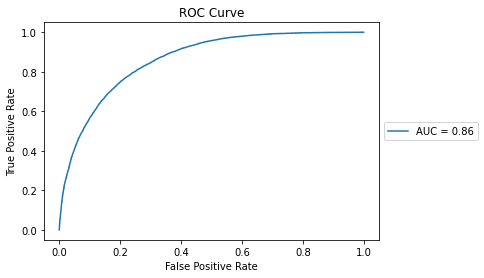

RandomForestClassifier


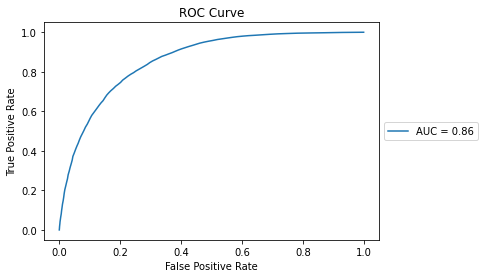

LogisticRegression


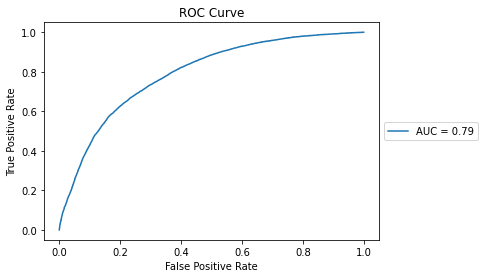

In [6]:
warnings.filterwarnings("ignore")

classifiers = [
    xgb.XGBClassifier(objective='binary:logistic', random_state=0, eval_metric='logloss'),
    RandomForestClassifier(random_state=0),
    LogisticRegression(random_state=0)]


for clf in classifiers:
    print(str(clf).split('(')[0])
    clf.fit(X_train, y_train)

    # predict probability scores on the test set
    y_pred_prob = clf.predict_proba(X_test)[:, 1]

    # calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # plot the ROC curve
    fig = plt.figure()
    ax = plt.subplot(1, 1, 1)
    ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()